**BigMart Sales Prediction practice problem**

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). We need to predict the sales for test data set.


* Item_Identifier: Unique product ID

* Item_Weight: Weight of product

* Item_Fat_Content: Whether the product is low fat or not

* Item_Visibility: The % of total display area of all products in a store allocated to the particular product

* Item_Type: The category to which the product belongs

* Item_MRP: Maximum Retail Price (list price) of the product

* Outlet_Identifier: Unique store ID

* Outlet_Establishment_Year: The year in which store was established

* Outlet_Size: The size of the store in terms of ground area covered

* Outlet_Location_Type: The type of city in which the store is located

* Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

* Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

**Load Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


**Data Mining**

In [104]:
train = pd.read_csv('C:/Users/ADMIN/OneDrive/Desktop/project prepleaf/train.csv')
test = pd.read_csv('C:/Users/ADMIN/OneDrive/Desktop/project prepleaf/test.csv')

**Exploratory Data Analysis**

In [105]:
train.shape#, test.shape

(8523, 12)

In [106]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [107]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

We need to predict Item_Outlet_Sales for given test data

lets first merge the train and test data for Exploratory Data Analysis


In [108]:
train['source'] = 'train'
test['source'] = 'test'
test['Item_Outlet_Sales'] = 0
data = pd.concat([train, test], sort = False)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 13) (14204, 13)


In [109]:
data['Item_Outlet_Sales'].describe()

count    14204.000000
mean      1308.865489
std       1699.791423
min          0.000000
25%          0.000000
50%        559.272000
75%       2163.184200
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

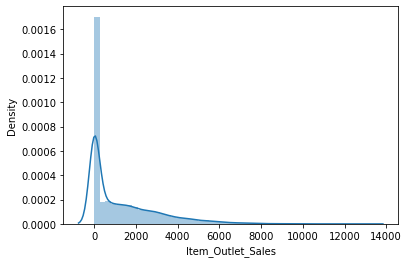

In [110]:
sns.distplot(data['Item_Outlet_Sales'])

1. Deviate from the normal distribution.
1. Have appreciable positive skewness.
1. Show peakedness.

In [111]:
print('Skewness: %f' % data['Item_Outlet_Sales'].skew())
print('Kurtsis: %f' %data['Item_Outlet_Sales'].kurt())

Skewness: 1.544684
Kurtsis: 2.419439


Lets look at numerical and categorial variables

In [112]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

In [113]:
categorial_features = data.select_dtypes(include=[np.object])
categorial_features.head(2)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,source
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,train
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,train


In [114]:
num_data = data.select_dtypes(include=[np.number])
num_data.head(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228


In [115]:
data['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

**Finding Missing values**

In [116]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

**Some observations:**

*  **Item_Visibility** has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.

* **Outlet_Establishment_Years** vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

* The lower ‘count’ of **Item_Weight** and **Outlet_Size** confirms the findings from the missing value check.

In [117]:
data.apply(lambda x : len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

This tells us that there are 1559 products and 10 outlets/stores (which was also mentioned in problem statement). Another thing that should catch attention is that Item_Type has 16 unique values. Let’s explore further using the frequency of different categories in each nominal variable.

In [118]:
#frequency of categories
for col in categorial_features:
    print('\n%s column: '%col)
    print(data[col].value_counts())


Item_Identifier column: 
FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content column: 
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Item_Type column: 
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Outlet_Identifier column: 
OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548


**Data Cleaning and Imputing Missing Values**

We found two variables with missing values – Item_Weight and Outlet_Size. Lets impute the former by the average weight of the particular item. This can be done as:

In [119]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

missing_values = data['Item_Weight'].isnull()
print('Missing values: %d' %sum(missing_values))

data.loc[missing_values,'Item_Weight']  = data.loc[missing_values,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
print('Missing values after immputation %d' %sum(data['Item_Weight'].isnull()))

Missing values: 2439
Missing values after immputation 0


This confirms that the column has no missing values now. Lets impute Outlet_Size with the mode of the Outlet_Size for the particular type of outlet.

In [120]:
mode_of_Outlet_size = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [121]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [122]:
miss_values = data['Outlet_Size'].isnull()  
miss_values

0       False
1       False
2       False
3        True
4       False
        ...  
5676    False
5677    False
5678     True
5679     True
5680     True
Name: Outlet_Size, Length: 14204, dtype: bool

In [123]:
data.loc[miss_values, 'Outlet_Size'] = data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [124]:
data['Outlet_Size'].isnull().sum()

0

**Modify Item_Visibility**

We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [125]:
data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].mean()], inplace=True)

**Create a broad category of Type of Item**

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [126]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

**Modify categories of Item_Fat_Content**

We found typos and difference in representation in categories of Item_Fat_Content variable. This can be corrected as:

In [127]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [128]:
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Type_Combined
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,Food
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,Drinks
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,Food
3,FDX07,19.200,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,Food
4,NCD19,8.930,Low Fat,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,Non-Consumable
5,FDP36,10.395,Regular,0.065953,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,train,Food
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,train,Food
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,train,Food
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986,train,Food
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350,train,Food


**Numerical and One-Hot Coding of Categorical variables**

In [129]:
data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Type_Combined
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,Food
3,FDX07,19.20,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,Food
4,NCD19,8.93,Low Fat,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,Non-Consumable


In [130]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Type','Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined',])

In [131]:
data.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Outlet_Identifier                     object
Outlet_Establishment_Year              int64
Item_Outlet_Sales                    float64
source                                object
Item_Type_Baking Goods                 uint8
Item_Type_Breads                       uint8
Item_Type_Breakfast                    uint8
Item_Type_Canned                       uint8
Item_Type_Dairy                        uint8
Item_Type_Frozen Foods                 uint8
Item_Type_Fruits and Vegetables        uint8
Item_Type_Hard Drinks                  uint8
Item_Type_Health and Hygiene           uint8
Item_Type_Household                    uint8
Item_Type_Meat                         uint8
Item_Type_Others                       uint8
Item_Type_Seafood                      uint8
Item_Type_Snack Foods                  uint8
Item_Type_

In [132]:
import warnings
warnings.filterwarnings('ignore')
#Drop the columns which have been converted to different types:
data.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

Now our data is ready for model building

In [133]:
# Model Building
# Reading modified data

train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")

In [134]:
train.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Combined_Drinks,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable
0,9.30,0.016047,249.8092,3735.1380,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
1,5.92,0.019278,48.2692,443.4228,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,17.50,0.016760,141.6180,2097.2700,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,19.20,0.065953,182.0950,732.3800,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
4,8.93,0.065953,53.8614,994.7052,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [135]:
#train test split
X = train.drop(['Item_Outlet_Sales'], axis=1)
Y = train['Item_Outlet_Sales']

In [136]:
Y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.3, random_state = 100)

# Linear Regression Model:

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score



In [139]:
reg =LinearRegression()

In [140]:
reg.fit(X_train, Y_train)

LinearRegression()

In [141]:
Y_pred = reg.predict(X_test)

Y_pred


array([2930.60997782, 4123.67137611, 4427.86730385, ...,  804.16721645,
       2112.82628751, 1420.39952543])

In [142]:
print(metrics.mean_squared_error(Y_test, Y_pred))


print(metrics.mean_squared_error(Y_pred, Y_test))


1280324.6165716602
1280324.6165716602


In [143]:
np.sqrt(metrics.mean_squared_error(Y_pred, Y_test))


1131.5143024158644

In [144]:
metrics.r2_score(Y_test, Y_pred)


0.5486268830127189

In [145]:
for i in num_data:
    num_data[i] = stats.zscore(num_data[i])

num_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,NaN,-0.969852,1.752511,0.139681,1.427445
1,NaN,-0.907063,-1.493696,1.334228,-0.509164
2,NaN,-0.956000,0.009874,0.139681,0.463841
3,NaN,-1.281712,0.661838,0.020226,-0.339163
4,NaN,-1.281712,-1.403623,-1.293777,-0.184829


In [146]:
from sklearn.preprocessing import LabelEncoder

In [147]:
encoder = LabelEncoder()

In [148]:
train['Item_Outlet_Sales'] = encoder.fit_transform(train['Item_Outlet_Sales'])


In [149]:
train['Item_Outlet_Sales']

0       2540
1        422
2       1639
3        670
4        865
        ... 
8518    2047
8519     516
8520    1018
8521    1466
8522     697
Name: Item_Outlet_Sales, Length: 8523, dtype: int64

In [150]:
#train test split
X = train.drop(['Item_Outlet_Sales'], axis=1)
Y = train['Item_Outlet_Sales']

In [151]:
X.dtypes

Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Item_Type_Baking Goods                 int64
Item_Type_Breads                       int64
Item_Type_Breakfast                    int64
Item_Type_Canned                       int64
Item_Type_Dairy                        int64
Item_Type_Frozen Foods                 int64
Item_Type_Fruits and Vegetables        int64
Item_Type_Hard Drinks                  int64
Item_Type_Health and Hygiene           int64
Item_Type_Household                    int64
Item_Type_Meat                         int64
Item_Type_Others                       int64
Item_Type_Seafood                      int64
Item_Type_Snack Foods                  int64
Item_Type_Soft Drinks                  int64
Item_Type_Starchy Foods                int64
Item_Fat_Content_Low Fat               int64
Item_Fat_Content_Regular               int64
Outlet_Location_Type_Tier 1            int64
Outlet_Loc

In [152]:
X.head(1)

,Item_Weight,Item_Visibility,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Combined_Drinks,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable
0,9.3,0.016047,249.8092,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0


In [153]:
Y

0       2540
1        422
2       1639
3        670
4        865
        ... 
8518    2047
8519     516
8520    1018
8521    1466
8522     697
Name: Item_Outlet_Sales, Length: 8523, dtype: int64

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve

In [156]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.3, random_state = 100)

In [157]:
rf=RandomForestClassifier()

In [ ]:
rf.fit(X_train,Y_train)

In [ ]:
y_train_pred=rf.predict(X_train)

In [ ]:
print('Train accuracy',accuracy_score(Y_train,y_train_pred))

In [ ]:
y_test_pred=rf.predict(x_test)

In [ ]:
print('Test accuracy',accuracy_score(y_test,y_test_pred))

In [ ]:
print(classification_report(y_test,y_test_pred))

In [ ]:
roc_auc_score(y_test,y_test_pred)